- This script is an implementation of HIAC algorithm from the paper [How to improve the accuracy of clustering algorithms](<../../paper/papers to research/2023_How to improve the accuracy of clustering algorithms.pdf>)
- This script is written by Thai

In [1]:
from HIAC import *

In [2]:
# initialization and parameter config
global photoPath
filePath = "data-sets/real-datasets/Wireless_indoor_location.txt"  # the path of dataset
file_name, _ = filePath.split("/")[-1].split(".")  # get file name

# the path of labels of dataset (if txt file does not contains labels)
labelPath = ""
save_dir = os.path.join(".", "implementation-by-thai", file_name)  # make new dir to save files
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with_label = True  # Whether the txt file contains both data and labels, if that, the labels must be in the last column
k = 6  # the number of nearest neighbors, parameter k in HIAC
T = 0.3  # parameter T in HIAC
d = 4  # the d in paper HIAC
threshold = 1.514  # the weight threshold to clip invalid-neighbors

# High-dimensional data are displayed using PCA dimensionality reduction methods
pca = dec.PCA(n_components=2)  

In [3]:
# read data and label
data = np.loadtxt(filePath)
if with_label:
    labels = data[:, -1]
    labels = np.array(labels, dtype=np.int32)
    data = data[:, :-1]
else:
    labels = np.loadtxt(labelPath, dtype=np.int32)

dim = data.shape  # the dimension of data
print(f"The dimension of the dataset: {dim}")

cluster_num = max(labels) - min(labels) + 1  # the number of clusters
print(f"The number of clusters: {cluster_num}")

The dimension of the dataset: (2000, 7)
The number of clusters: 4


In [4]:
# normalization
data_without_nml = data.copy()
for j in range(data.shape[1]):
    max_ = max(data[:, j])
    min_ = min(data[:, j])
    if max_ == min_:
        continue
    for i in range(data.shape[0]):
        data[i][j] = (data[i][j] - min_) / (max_ - min_)

np.savetxt(os.path.join(save_dir, file_name + "_normalization.txt"), data)

In [5]:
def myPlot(data, labels, title, photoPath):
    """
    This version is written by Thai
    
    Parameters
    ----------
    data:
    labels:
    title: the title of graph
    photoPath

    Returns: the clustering graph
    -------

    """
    global num
    plt.figure(num)
    num += 1
    sortNumMax = np.max(labels)
    sortNumMin = np.min(labels)
    color = [
        "#125B50",
        "#4D96FF",
        "#FFD93D",
        "#FF6363",
        "#CE49BF",
        "#22577E",
        "#4700D8",
        "#F900DF",
        "#95CD41",
        "#FF5F00",
        "#40DFEF",
        "#8E3200",
        "#001E6C",
        "#C36A2D",
        "#B91646",
    ]
    lineform = ["o"]
    for i in range(sortNumMin, sortNumMax + 1):
        Together = []
        flag = 0
        for j in range(data.shape[0]):
            if labels[j] == i:
                flag += 1
                Together.append(data[j])
        Together = np.array(Together)
        Together = Together.reshape(-1, data.shape[1])
        fontSize = 15
        colorNum = (i - sortNumMin) % len(color)
        formNum = 0
        plt.scatter(
            Together[:, 0], Together[:, 1], fontSize, color[colorNum], lineform[formNum]
        )
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    plt.title(title, fontsize=20)
    plt.savefig(photoPath, dpi=300, bbox_inches="tight")
    plt.show()


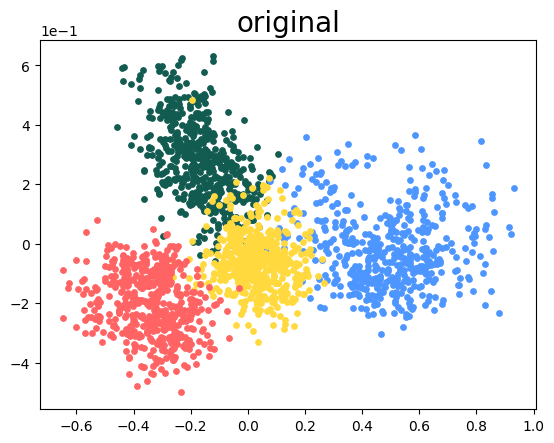

In [6]:
# use PCA to reduce the dimension of the dataset, and visualization
if dim[1] > 2:  # for high dimension dataset
    dataPCA = pca.fit_transform(data)
    photoPath = os.path.join(save_dir, file_name + "_after_pca.png")
    myPlot(dataPCA, labels, "original", photoPath)
else:  # for dataset has two dimensions
    photoPath = os.path.join(save_dir, file_name + "_original.png")
    myPlot(data, labels, "original", photoPath)

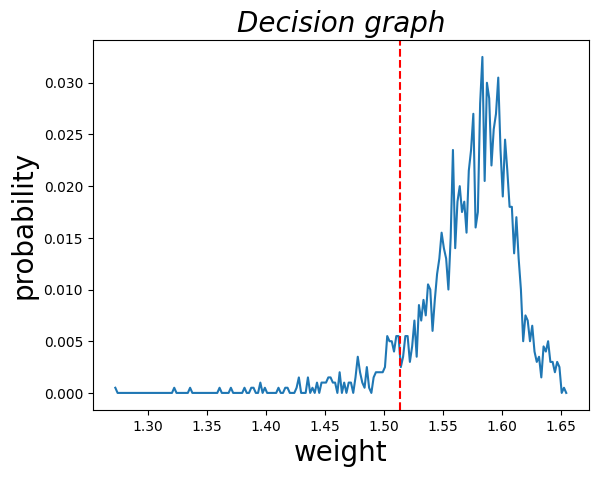

In [7]:
# call HIAC
photoPath = os.path.join(save_dir, "decision_" + str(k) + "_" + str(threshold) + ".png")  # the path to save picture (decision-graph)
distanceTGP = TGP(data, k, photoPath, threshold)  # we can determine the threshold，and return the weight matrix
neighbor_index = prune(data, k, threshold, distanceTGP)  # clip invalid-neighbors based on the weight threshold and the decision-graph,
# and then return the index matrix which records the valid-neighbors index of object i
# for object i, if j is invalid-neighbor of i, neighbor_index[i][j] = -1,
# else neighbor_index[i][j] is the index of object j
# its necessary for you to know that we only need K-nearest-neighbor of each object,
# so,

for i in range(d):  # ameliorated the dataset by d time-segments
    bata = shrink(data, k, T, neighbor_index)
    data = bata
np.savetxt(os.path.join(save_dir, file_name + "_ameliorated_by_HIAC.txt"), data)

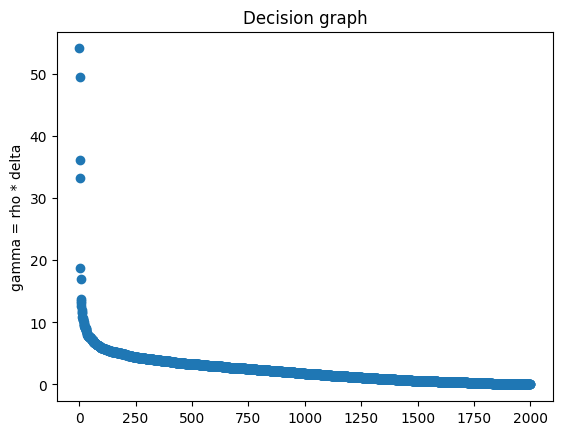

nmi:   0.9370184723746248


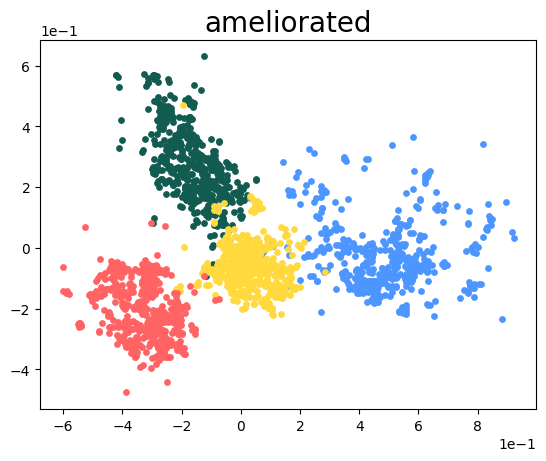

In [8]:
# call DPC to clustering, and calculate nmi by the interface:adjusted_mutual_info_score
res = DPC(data, cluster_num)
nmi = metrics.adjusted_mutual_info_score(labels, res, average_method="max")
print("nmi:  ", nmi)

# use PCA to reduce the dimension of dataset after ameliorating, and visualization
dataPCA = data.copy()
if dim[1] > 2:
    dataPCA = pca.fit_transform(data)
    photoPath = os.path.join(save_dir, file_name + "_after_pca.png")
    myPlot(dataPCA, labels, "ameliorated", photoPath)
else:
    photoPath = os.path.join(save_dir, file_name + "_ameliorated_by_HIAC.png")
    myPlot(data, labels, "ameliorated", photoPath)